<a href="https://colab.research.google.com/github/Karlajack/MachineLearning1/blob/main/Credit_Risk_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setting the Background**

The most pressing questions for banks are how efficiently can we guage the risk profile of our customers and how can we use this information to decide on the required liquidity while still maintaining our regulatory obligations.

With the constantly changing customer portfolio and the ever increasing customer base a more robust non-hardcoded approach is neccessary to achieve these antagonistic goals.

Thus comes the idea of using machine learning to develop a behavioural scorecard to pull data from both internal sources, customer transactions and their demographic data, to predict the probability of default.

In this notebook we are going to explore the data cleaning and transformation as well as machine learing modelling in predicting probability of default. We can then use these results to develop a credit rating.

We will eplore the following concepts in the notebook

Data cleaning - Struucturing the data for modelling
What to do with missing values
How to deal with class imbalance and the implications.

# 2. Libraries and Data Import

In [1]:
# General Libraries

import warnings
warnings.filterwarnings('ignore')

# Data Explotation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #Visualization
import seaborn as sns #Advanced Visualization
%matplotlib inline
import random

# Data modelling libraries
from sklearn.impute import SimpleImputer
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler,PolynomialFeatures,MinMaxScaler,RobustScaler,LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression,Ridge,Lasso,LogisticRegression
from sklearn.svm import LinearSVR,SVR,NuSVR,SVC
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error,r2_score

from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import f1_score

In [50]:
#Loading data
Loan = pd.read_csv("/content/raw-data.csv")
Loan.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32
0,1,0,0,24.0,0.0,2432.0,46500.0,24.0,1385.0,SC,...,NaN,NaN,46500.0,NaN,NaN,0,0,0,TIER 1,0
1,2,0,1,24.0,1.0,1495.0,28168.0,24.0,2496.0,MO,...,NaN,NaN,28168.0,NaN,NaN,0,0,0,TIER 1,0


In [51]:
#Renaming columns in the dataset with their correct names
Loan_renamed = Loan.rename(columns={'V1': 'Customer ID',
'V2': 'Customer has bounced in first EMI',
'V3': 'No of times bounced 12 months',
'V4': 'Maximum MOB',
'V5': 'No of times bounced while repaying the loan',
'V6': 'EMI',
'V7': 'Loan Amount',
'V8': 'Tenure',
'V9': 'Dealer codes from where customer has purchased the Two wheeler',
'V10': 'Product code of Two wheeler',
'V11': 'No of advance EMI paid',
'V12': 'Rate of interest',
'V13': 'Gender',
'V14': 'Employment type',
'V15': 'Resident type of customer',
'V16': 'Date of birth',
'V17': 'Customer age when loanwas taken',
'V18': 'No of loans',
'V19': 'No of secured loans',
'V20': 'No of unsecured loans',
'V21': 'Max amount sanctioned in the Live loans',
'V22': 'No of new loans in last 3 months',
'V23': 'Total sanctioned amount in the secured Loans which are Live',
'V24': 'Total sanctioned amount in the unsecured Loans which are Live',
'V25': 'Maximum amount sanctioned for any Two wheeler loan',
'V26': 'Time since last Personal loan taken (in months)',
'V27': 'Time since first consumer durables loan taken (in months)',
'V28': 'No of times 30 days past due in last 6 months',
'V29': 'No of times 60 days past due in last 6 months',
'V30': 'No of times 90 days past due in last 3 months',
'V31': 'Tier',
'V32': 'Target variable'})
Loan_renamed.head(2)

,Customer ID,Customer has bounced in first EMI,No of times bounced 12 months,Maximum MOB,No of times bounced while repaying the loan,EMI,Loan Amount,Tenure,Dealer codes from where customer has purchased the Two wheeler,Product code of Two wheeler,...,Total sanctioned amount in the secured Loans which are Live,Total sanctioned amount in the unsecured Loans which are Live,Maximum amount sanctioned for any Two wheeler loan,Time since last Personal loan taken (in months),Time since first consumer durables loan taken (in months),No of times 30 days past due in last 6 months,No of times 60 days past due in last 6 months,No of times 90 days past due in last 3 months,Tier,Target variable
0,1,0,0,24.0,0.0,2432.0,46500.0,24.0,1385.0,SC,...,NaN,NaN,46500.0,NaN,NaN,0,0,0,TIER 1,0
1,2,0,1,24.0,1.0,1495.0,28168.0,24.0,2496.0,MO,...,NaN,NaN,28168.0,NaN,NaN,0,0,0,TIER 1,0


# 3. Basic EDA and Data Cleaning

In [25]:
Loan_renamed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119528 entries, 0 to 119527
Data columns (total 32 columns):
 #   Column                                                          Non-Null Count   Dtype  
---  ------                                                          --------------   -----  
 0   Customer ID                                                     119528 non-null  int64  
 1   Customer has bounced in first EMI                               119528 non-null  int64  
 2   No of times bounced 12 months                                   119528 non-null  int64  
 3   Maximum MOB                                                     85048 non-null   float64
 4   No of times bounced while repaying the loan                     85048 non-null   float64
 5   EMI                                                             85048 non-null   float64
 6   Loan Amount                                                     85048 non-null   float64
 7   Tenure                                

As illustrated there are quite a number of features with missing values, we will speak to this in the subsequent sections

In [5]:
#Removing irrelevant columns
# #irrelevant_columns = ['Time since first consumer durables loan taken (in months)','Time since last Personal loan taken (in months)']
Loan_renamed.drop(['Time since first consumer durables loan taken (in months)','Time since last Personal loan taken (in months)'], axis = 1, inplace = True)
Loan_renamed.shape

(119528, 30)

In [19]:
# Missing values treatment
Loan_renamed.dropna(axis=0,how='any',subset=['Loan Amount','Gender'],inplace=True)

KeyError: ['Gender']

In [ ]:
#correlation matrix
corrmat = Loan_renamed.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(Loan_renamed[top_corr_features].corr(),annot=True,cmap="viridis")

In [ ]:
# Getting the number of positive and negative examples.
plt.figure(figsize=(15,5))
sns.countplot(Loan_renamed['Target variable'])
plt.xticks((0, 1), ["Non-Defaulter", "Defaulter"])
plt.xlabel("")
plt.ylabel("Count")
plt.title("Class counts", y=1, fontdict={"fontsize": 20})

print(Loan_renamed['Target variable'].value_counts())

AttributeError: module 'seaborn' has no attribute 'bahplot'

<Figure size 1500x500 with 0 Axes>

The data set is pretty imbalanced as expected where positive examples defualters are significanltly less than 25%. We'll explain in the next section how to handle all of them after giving an overview of ensemble methods

<Axes: title={'center': 'Loan Amount (Box Plot)'}, xlabel='Employment type', ylabel='Loan Amount'>

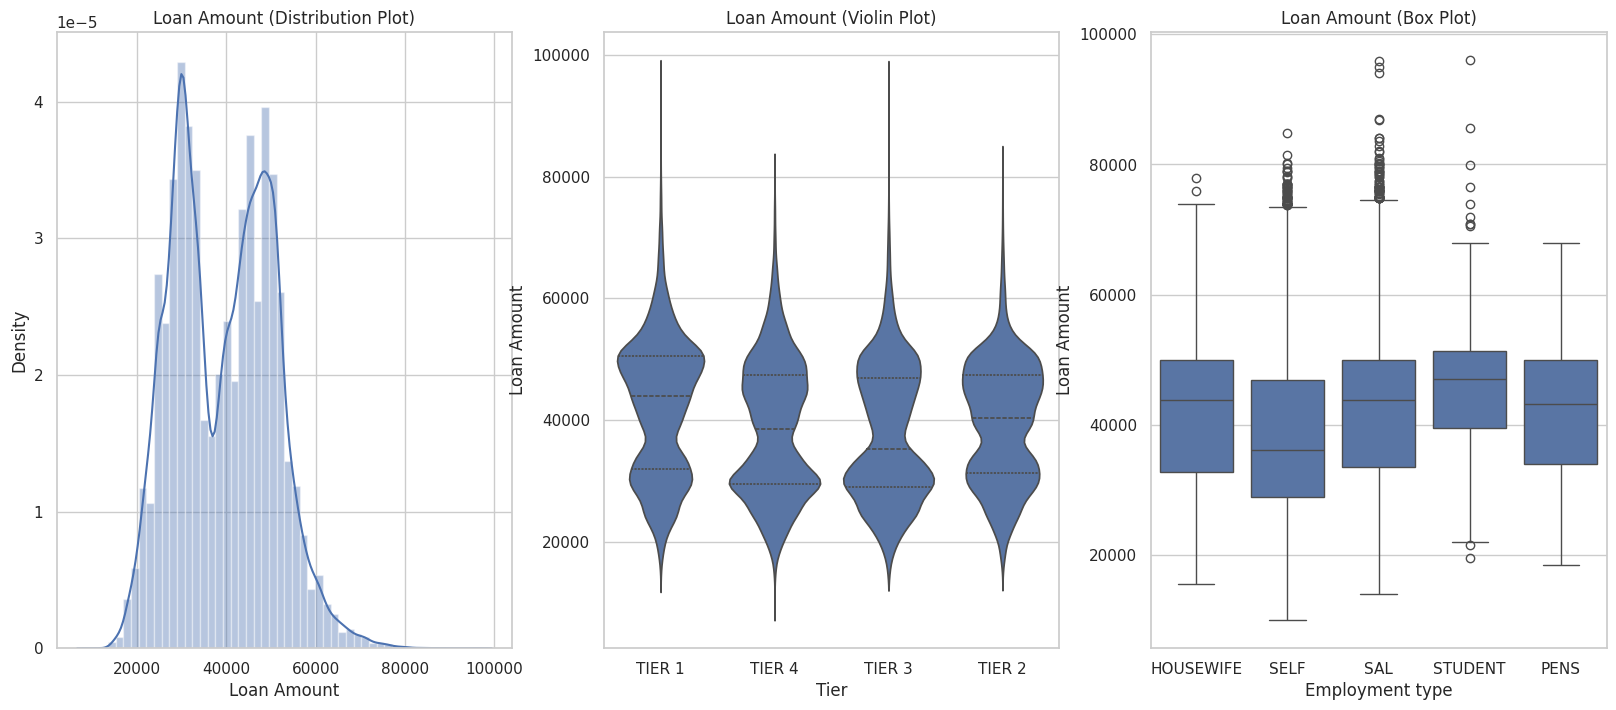

In [ ]:
sns.set(style="whitegrid")

fig, ax=plt.subplots(nrows =1,ncols=3,figsize=(20,8))
ax[0].set_title("Loan Amount (Distribution Plot)")
sns.distplot(Loan_renamed['Loan Amount'],ax=ax[0])
ax[1].set_title("Loan Amount (Violin Plot)")
sns.violinplot(data =Loan_renamed, x='Tier',y='Loan Amount',ax=ax[1], inner="quartile")
ax[2].set_title("Loan Amount (Box Plot)")
sns.boxplot(data =Loan_renamed, x='Employment type',y='Loan Amount',ax=ax[2],orient='v')

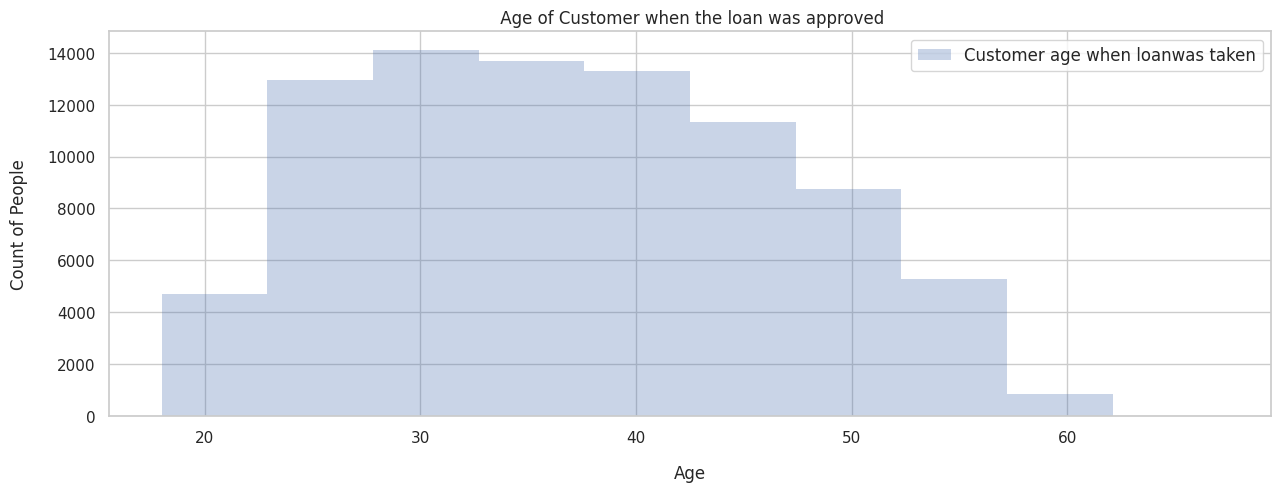

In [ ]:
##Age- age at which the client took the loan
plt.figure(figsize=(15,5))

#bar plot
Loan_renamed['Customer age when loanwas taken'].plot(kind='hist',color='b',alpha=0.3, edgecolor='none')
plt.xlabel("Age", labelpad=14)
plt.ylabel("Count of People", labelpad=14)
plt.title(" Age of Customer when the loan was approved")
plt.legend(loc="best",prop={"size":12})

In [ ]:
# Explore correlation between age and loan amount
plt.figure(figsize=(15,5))
sns.scatterplot(x=Loan_renamed['Customer age when loanwas taken'],y='Loan Amount',data=Loan_renamed)

In [12]:
 gender = pd.get_dummies(Loan_renamed['Gender'])
 Loan_renamed=pd.concat([Loan_renamed,gender], axis=1)
Loan_renamed = Loan_renamed.drop('Gender', axis=1)

In [54]:
dropped=['Time since first consumer durables loan taken (in months)','Time since last Personal loan taken (in months)',
'Max amount sanctioned in the Live loans','Total sanctioned amount in the secured Loans which are Live',
'Total sanctioned amount in the unsecured Loans which are Live','Maximum amount sanctioned for any Two wheeler loan']

Loan_renamed.drop(dropped,axis=1,inplace=True)

KeyError: "['Time since first consumer durables loan taken (in months)', 'Time since last Personal loan taken (in months)', 'Max amount sanctioned in the Live loans', 'Total sanctioned amount in the secured Loans which are Live', 'Total sanctioned amount in the unsecured Loans which are Live', 'Maximum amount sanctioned for any Two wheeler loan'] not found in axis"

#4. DATA CLEANING

In [55]:
data=Loan_renamed.copy()

4.1 Imputing missing values

To do, investigate them first and document the case for imputation, we might need to drop them.

In [75]:
CatVariables = data.select_dtypes(include=['object'])
NumVariables = data.select_dtypes(include=['float','int'])




In [76]:
#standardizing column names for easier usage
data.columns=data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
CatVariables=CatVariables.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
NumVariables=NumVariables.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')


Strategies to deal with missing value
Almost always real world data sets have missing values. This can be due, for example, users didn't fill some part of the forms or some transformations happened while collecting and cleaning the data before they send it to you. Sometimes missing values are informative and weren't generated randomly. Therefore, it's a good practice to add binary features to check if there is missing values in each row for each feature that has missing values.

In our case, a number of the variables have missing values consistently pointing to a lapse in the data generation process. Thus we will consider deleting these observations only after exploring the performance of the model with imputed values. Columns with a significant portion of the observations missing will be dropped as the model we have opted for does not take in missing values.

Below are some of the most common strategies for dealing with missing values:\n",

Simply delete all examples that have any missing values. This is usually done if the missing values are very small compared to the size of the data set and the missing values were random. In other words, the added binary features did not improve the model. One disadvantage for this strategy is that the model will throw an error when test data has missing values at prediction.

Impute the missing values using the mean of each feature separately

Impute the missing values using the median of each feature separately.

Use Multivariate Imputation by Chained Equations (MICE). The main disadvantage of MICE is that we can't use it as a transformer in sklearn pipelines and it requires to use the full data set when imputing the missing values. This means that there will be a risk of data leakage since we're using both training and test sets to impute the missing values.

The following steps explain how MICE works:

First step: Impute the missing values using the mean of each feature separately.
Second step: For each feature that has missing values, we take all other features as predictors (including the ones that had missing values) and try to predict the values for this feature using linear regression for example. The predicted values will replace the old values for that feature. We do this for all features that have missing values, i.e. each feature will be used once as a target variable to predict its values and the rest of the time as a predictor to predict other features' values. Therefore, one complete cycle (iteration) will be done once we run the model
 times to predict the
 features that have missing values. For our data set, each iteration will run the linear regression 6 times to predict the 6 features.
Third step: Repeat step 2 until there is not much of change between predictions.
Impute the missing values using K-Nearest Neighbors. We compute distance between all examples (excluding missing values) in the data set and take the average of k-nearest neighbors of each missing value. There's no implementation for it yet in sklearn and it's pretty inefficient to compute it since we'll have to go through all examples to calculate distances. Therefore, we'll skip this strategy in this notebook.
To evaluate each strategy, we'll use Random Forest classifier with hyperparameters' values guided by Data-driven Advice for Applying Machine Learning to Bioinformatics Problems as a starting point.

Let's first create binary features for missing values and then prepare the data for each strategy discussed above. Next, we'll compute the 10-folds cross validation AUC score for all the models using training data."

In [77]:
#For quantitative data

numerical_cols = data[NumVariables]
categorical_cols = data[CatVariables]

imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
lat = imp_mean.fit_transform(numerical_cols)
imp_mode = SimpleImputer(missing_values=np.nan,strategy='most_frequent')
g_se = imp_mode.fit_transform(categorical_cols)

In [72]:
data[CatVariables]=g_se
data[NumVariables]=lat

# 4.2 Encoding

Label encoding
We can use LabelEncoder to encode our variable to numbers. What a label encoder essentially does is that it sees the first value in the column and converts it to 0, next value to 1 and so on.The integer values have a natural ordered relationship between each other and machine learning algorithms may be able to understand and harness this relationship. This approach works reasonably well with tree models

One hot encoding
For categorical variables where no such ordinal relationship exists, the integer/label encoding does not suffice. In fact, using this encoding and allowing the model to assume a natural ordering between categories may result in poor performance or unexpected results (predictions halfway between categories).

In this case, a one-hot encoding can be applied to the integer representation. This is where the integer encoded variable is removed and a new binary variable is added for each unique integer value.

So if we have n levels in a category, we will get n-1 features.

In [80]:
# Dealing with categorical columns
# Label Encoding for object to numeric conversion
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feature in CatVariables:
    data[feature] = le.fit_transform(data[feature].astype(str))

In [81]:
data.head(2)

,customer_id,customer_has_bounced_in_first_emi,no_of_times_bounced_12_months,maximum_mob,no_of_times_bounced_while_repaying_the_loan,emi,loan_amount,tenure,dealer_codes_from_where_customer_has_purchased_the_two_wheeler,product_code_of_two_wheeler,...,customer_age_when_loanwas_taken,no_of_loans,no_of_secured_loans,no_of_unsecured_loans,no_of_new_loans_in_last_3_months,no_of_times_30_days_past_due_in_last_6_months,no_of_times_60_days_past_due_in_last_6_months,no_of_times_90_days_past_due_in_last_3_months,tier,target_variable
0,1.0,0.0,0.0,24.0,0.0,2432.0,46500.0,24.0,1385.0,3,...,40.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0
1,2.0,0.0,1.0,24.0,1.0,1495.0,28168.0,24.0,2496.0,1,...,47.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0


**4.3 Class IMbalance**

In [83]:
X=data.drop(['customer_id','target_variable'],axis=1)
y=data[["target_variable"]]

SMOTE
S𝒚𝒏𝒕𝒉𝒆𝒕𝒊𝒄 𝒎𝒊𝒏𝒐𝒓𝒊𝒕𝒚 𝒐𝒗𝒆𝒓𝒔𝒂𝒎𝒑𝒍𝒊𝒏𝒈 𝒕𝒆𝒄𝒉𝒏𝒊𝒒𝒖𝒆- creates examples of the minority class by looking at the distribution of the minority class and "guesses" what the other cases would have been

pick two points that are relatively closer to each other distance wise
draw a line
generate a new point along that line
It doesn't always work but a lot of time it works and it is a good technique to look at when there is no way of generating more data and the aforementioned techniques are not applicable per se It is better for increasing precision(𝙥𝙤𝙨𝙞𝙩𝙞𝙫𝙚 𝙞𝙙𝙚𝙣𝙩𝙞𝙛𝙞𝙚𝙙 𝙖𝙨 𝒕𝒉𝒂𝒕 𝒂𝒓𝒆 𝒑𝒐𝒔𝒊𝒕𝒊𝒗𝒆 ) but this comes at the cost of recall (𝒐𝒖𝒕 𝒐𝒇 𝒂𝒍𝒍 𝒕𝒉𝒆 𝒑𝒐𝒔𝒊𝒕𝒊𝒗𝒆𝒔 𝒘𝒉𝒊𝒄𝒉 𝒐𝒏𝒆𝒔 𝒉𝒂𝒗𝒆 𝒃𝒆𝒆𝒏 𝒄𝒐𝒓𝒓𝒆𝒄𝒕𝒍𝒚 𝒊𝒅𝒆𝒏𝒕𝒊𝒇𝒊𝒆𝒅)

array([[<Axes: title={'center': 'target_variable'}>]], dtype=object)

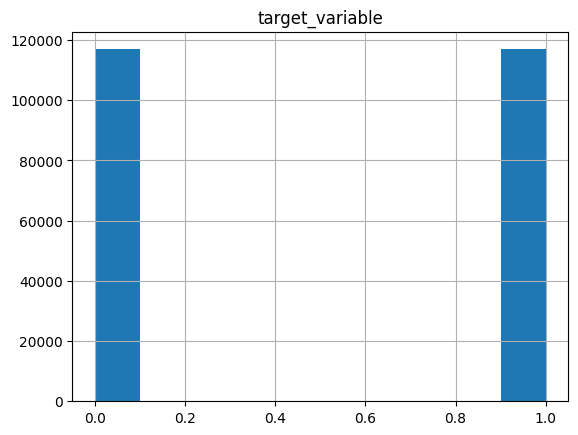

In [84]:
smote_sample=SMOTE(random_state=124,sampling_strategy='auto') # the sampling strategy can be one of float, str, dict or callable `float``,
#it corresponds to the desired ratio of the number of samples in the minority class over the number of samples in the majority class after resampling ie {1:500}
# ``'minority'``: resample only  minority class; 'not minority'``:all but the minority class; ``'not majority'``: all but the majority, ``'all'`` ,``'auto'``:
x_res, y_res=smote_sample.fit_resample(X,y)


# now plot the classes
y_res.hist()

With SMOTE we get a feature space with a similar distribution to the original data set, except that in this case we actually have a balanced ratio of the negative and positive examples. Thus our model should be able to learn the patterns associated with both defaults and non-defaults. Here we are interested in both an increase in precision and recall.

In [85]:
print(x_res.shape,y_res.shape)

(233828, 24) (233828, 1)


Challenge:
Explore the linear separabillity of the two classes and document your intuition of the best model type to give you the best results.
Document the effect of multicolleaniarity in model performance.
Try different classification models and optimize your output for the best result
Tune your model after learning these in Week 4 - The submission can be done without this step : It is worth noting that feature engineering is of much importance than hyperparametere tuning as the perfomance improvement with the latter is always only marginal
Generate Credit Scores based on the probability score from the model (Optional)
Identify which customers fall into what category, based on the below ranking methodologies
The following forms our basis for rank ordering
0 - 200 Bad Customer ,
201-350 2nd Worst,
351 - 500 Not So bad,
501 - 700 Ideal guys,
700> Big loans

# 5. Modelling with the balanced data

 1.Check for linear separabillity of the two classes

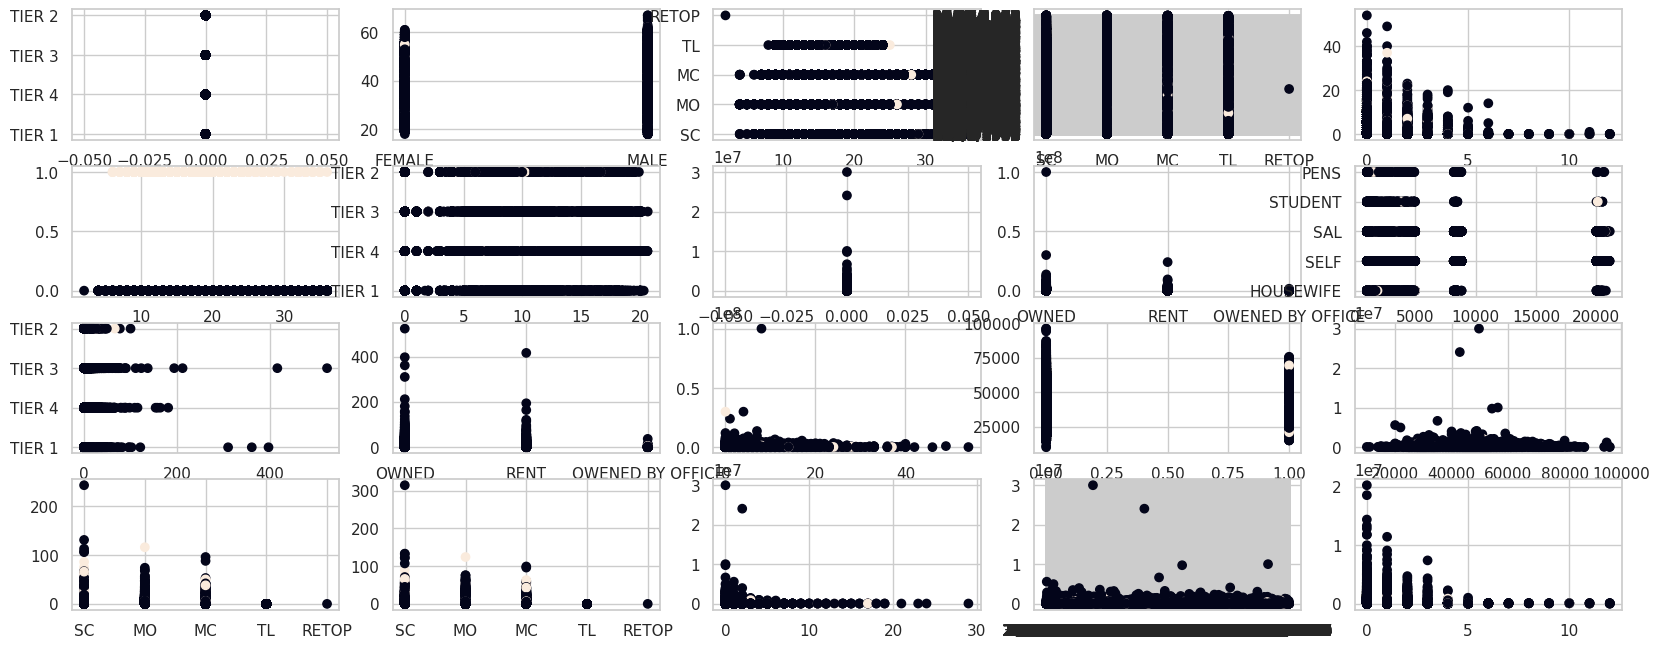

In [ ]:
#bivariate data analysis
comb=list(itertools.combinations([a for a in range (1,len(data.columns))],2)) # creating bivariate for all features
rand=random.choices(comb,k=20) #Randomly choose 20 bivariate relationship
fig=plt.figure(figsize=(20,20))
for i in range(len(rand)):
  ax=fig.add_subplot(10,5,i+1)
  plt.scatter(data[data.columns[rand[i][0]]],data[data.columns[rand[i][1]]],c=data.target_variable)


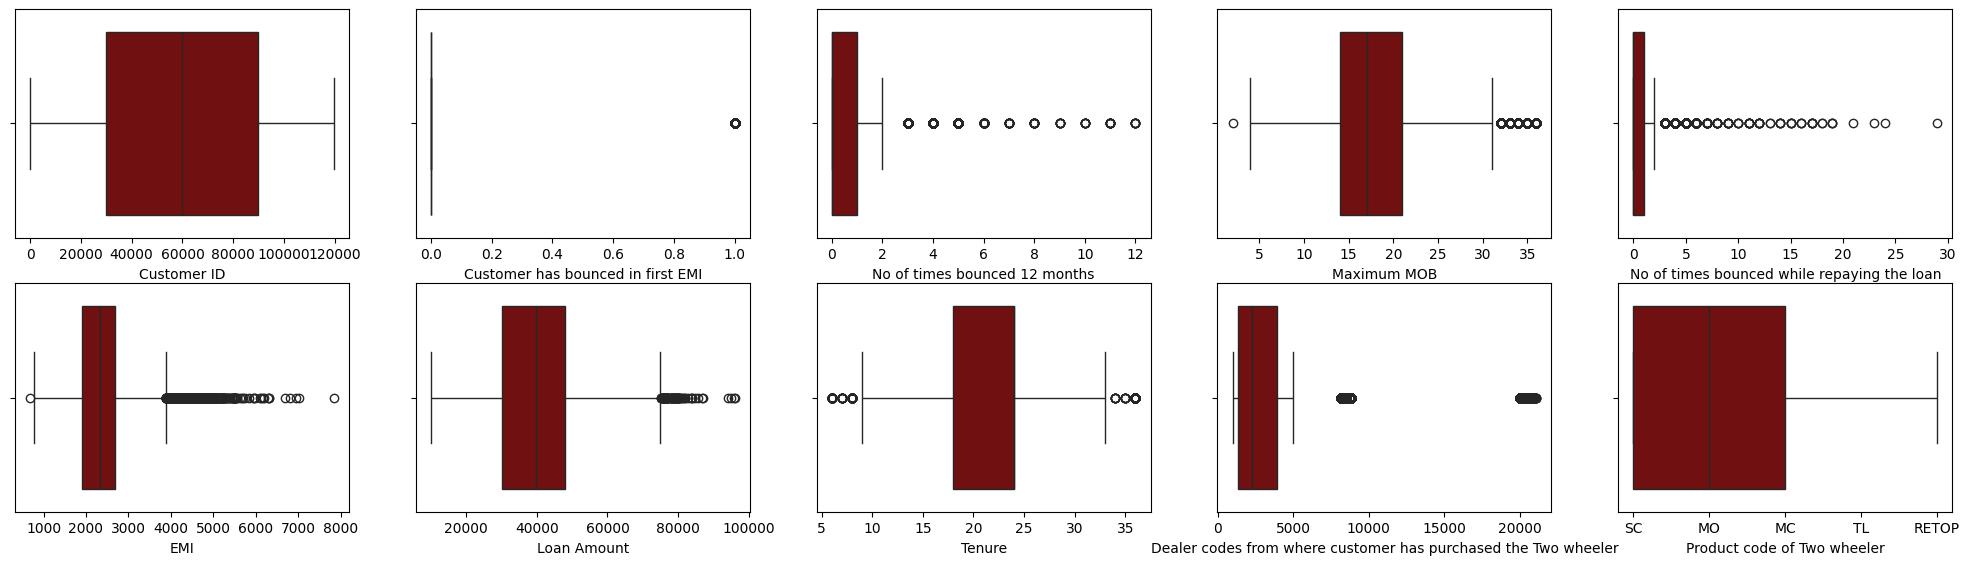

In [58]:
#univariate analysis for numerical features to check outliers
fig=plt.figure(figsize=(25,35))
for i,j in zip(data,range(10)):
  ax=fig.add_subplot(10,5,j+1)
  sns.boxplot(data=data,x=data[i],orient='v',color='Maroon')

**Insights**
Most features are not linearly separable for classification problem

Support vector machines and ensemble methods would be best models for this data

**Effect of multicolleaniarity in model performance**
Multicollinearity is a phenomenon where one or more independent variables are highly correlated with other independent variables in a regression model

Multicollinearity reduces the precision of the estimated coefficients, which weakens the statistical power of your regression model

It increase Co-efficient sensitivity.mall changes to the model could cause major changes to the coefficient estimates


In [ ]:

corr_df=data[numerical_cols].corr()
corr_df.head()


### **Modelling**

In [87]:
x=x_res
y=y_res

In [88]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=40)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(163679, 24) (70149, 24) (163679, 1) (70149, 1)


In [89]:
#Logistic regression
pipe=make_pipeline(PolynomialFeatures(degree=2),MinMaxScaler(),LogisticRegression(penalty='l2',solver='lbfgs',C=100))
scores=cross_val_score(pipe,x_train,y_train,cv=5,scoring="accuracy")

print(scores,scores.mean())

[0.80935362 0.80131965 0.80477151 0.79973118 0.80507102] 0.8040493955952156


In [ ]:
#support vector machine classification
pipe=make_pipeline(PolynomialFeatures(degree=3),MinMaxScaler(),SVC(kernel='rbf',C=25))
scores=cross_val_score(pipe,x_train,y_train,cv=5,scoring="accuracy")

print(scores,scores.mean())
